In [21]:
%matplotlib inline
import baltic as bt
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon ## for polygons
from descartes import PolygonPatch
import re

from matplotlib.collections import PatchCollection ## for polygons too
from matplotlib.colors import LinearSegmentedColormap ## for colour maps
from matplotlib import gridspec ## for composite figures
import matplotlib.patheffects as path_effects ## for elegant text
from IPython.display import clear_output
from IPython.display import HTML

from mpl_toolkits.mplot3d import axes3d
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import datetime
import math
import time
import sys
import unicodedata
# import unidecode ## for removing diacritics from example geoJSON

import pandas as pd

from collections import OrderedDict

import numpy as np
from scipy.interpolate import UnivariateSpline ## used to smooth counts of lineages in each location at any given time
from scipy.interpolate import interp1d ## used to linearly interpolate between data points used in colouring polygons
from sklearn.decomposition import IncrementalPCA ## used to identify PCA1 when automatically producing a colour map

import requests ## used to fetch examples from internet
import json ## used for importing JSONs
try:
    from StringIO import StringIO as sio
    from cStringIO import StringIO as csio
except ImportError:
    from io import StringIO as sio
    from io import BytesIO as csio
    
def removeDiacritics(string):
    """
    Removes diacritic marks from unicode.
    """
    return unicodedata.normalize('NFKD', string)

def calendarTimeline(start_date, end_date, infmt='%Y-%m-%d',outfmt='%Y-%b',optfmt=None,month_step=1):
    """
    Given two calendar dates returns a list of calendar dates at monthly (by default) intervals.
    """
    current_date = datetime.datetime.strptime(start_date,infmt)
    ending_date = datetime.datetime.strptime(end_date,infmt)
    
    timeline=[]
    while current_date <= ending_date:
        if optfmt and current_date.month!=1:
            d=datetime.datetime.strftime(current_date,optfmt)
        else:
            d=datetime.datetime.strftime(current_date,outfmt)
        timeline.append(d)
        carry, new_month = divmod(current_date.month - 1 + month_step, 12)
        new_month += 1
        current_date = current_date.replace(year=current_date.year + carry,month=new_month)
    return timeline

In [22]:
palms=pd.read_csv('../gbifpalms_onlynative_nocen_traitssoils_20200108.csv').dropna(subset=['shape'])
# palms.columns
palms_spp=pd.read_csv('./palms_alltraits_curated_20200331.csv',sep='\t')
palms

C:\Users\xtorrm\Documents\Python3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (6,7,8,9,10,12,18,20,21,22,23,24,25,26,27,28,29,32,33,38,51,70) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,num,index,species,decimalLatitude,decimalLongitude,Absent_0,Acaulescent,AverageFruitLength_cm,AverageFruitWidth_cm,...,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19
0,1,0,0,Chamaerops_humilis,36.897130,10.788890,1,2,1.3,1.44,...,256.0,108.0,306.0,66.0,1.0,73.0,161.0,12.0,21.0,142.0
1,2,1,1,Chamaerops_humilis,43.353640,5.418730,1,2,1.3,1.44,...,210.0,61.0,632.0,85.0,16.0,34.0,224.0,84.0,84.0,177.0
2,3,2,2,Hyophorbe_indica,-21.181780,55.535050,0,0,2.3,1.05,...,206.0,152.0,1588.0,260.0,50.0,50.0,685.0,182.0,685.0,222.0
3,4,3,3,Bactris_hatschbachii,-25.144167,-48.306111,1,0,2.05,2,...,234.0,157.0,2048.0,291.0,73.0,41.0,826.0,278.0,767.0,278.0
4,5,4,4,Syagrus_glaucescens,-18.270556,-43.797500,0,0,2.5,2.05,...,207.0,164.0,1423.0,327.0,8.0,86.0,797.0,27.0,558.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56366,56934,56933,56933,Trithrinax_campestris,-29.640000,-58.370000,1,0,0.8,1.15,...,255.0,142.0,1097.0,139.0,43.0,33.0,373.0,139.0,318.0,139.0
56367,56935,56934,56934,Chamaedorea_seifrizii,18.078833,-91.329436,0,0,0.8,0.8,...,285.0,235.0,1834.0,320.0,35.0,69.0,868.0,123.0,392.0,191.0
56368,56936,56935,56935,Chamaedorea_elatior,17.808333,-96.125000,0,0,1.5,0.95,...,243.0,192.0,3749.0,695.0,76.0,73.0,1892.0,254.0,818.0,350.0
56369,56937,56936,56936,Livistona_australis,-26.822852,152.888287,1,0,1.7,1.7,...,234.0,140.0,1808.0,265.0,45.0,49.0,783.0,201.0,706.0,254.0


In [23]:
list(palms.columns)
for row in palms.itertuples():
    if row.variation=='variable':
        palms.loc[row.Index,'shape']='variable'
print(palms['shape'].unique())

['cos-palmate' 'pinnate' 'variable' 'entire' 'bipinnate']


In [24]:
json_path='C:/Users/xtorrm/Documents/Palm_gap/wgsrpd-master/geojson/level3.geojson'
json_map=json.load(open(json_path,'r'))
features=json_map['features']
location_points={} ## location points will be stored here
polygons={} ## polygons will be stored here
locName='LEVEL3_COD' ## key name for each feature
for loc in features: ## iterate through features (locations)
    poly = np.asarray(loc['geometry']['coordinates']) ## get coordinates
    location=removeDiacritics(loc['properties'][locName]) ## standardised location name (remove diacritics)
    polygons[location]=[]
    location_points[location]=[]
    if loc['geometry']['type']=='MultiPolygon': ## multiple parts detected
        for part in np.asarray(poly): ## iterate over each component polygon
            for coords in np.asarray(part): ## iterate over coordinates
                coords=np.array(coords)
                xs=coords[:,0] ## longitudes
                ys=coords[:,1] ## latitudes
                location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
    if loc['geometry']['type']=='Polygon': ## location is single part
        for coords in np.asarray(poly): ## iterate over coordinates
            coords=np.array(coords)
            xs=coords[:,0] ## longitudes
            ys=coords[:,1] ## latitudes
            location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
    complete_location=[]
    for part in location_points[location]: ## iterate over each component of a location
        complete_location.append(Polygon(part,True)) ## create a polygon for each component of a location
    polygons[location]=complete_location ## assign list of polygons to a location
# print(polygons['CLM'])
## need to solve the issue below:
## C:\Users\xtorrm\Documents\Python3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

C:\Users\xtorrm\Documents\Python3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
C:\Users\xtorrm\Documents\Python3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


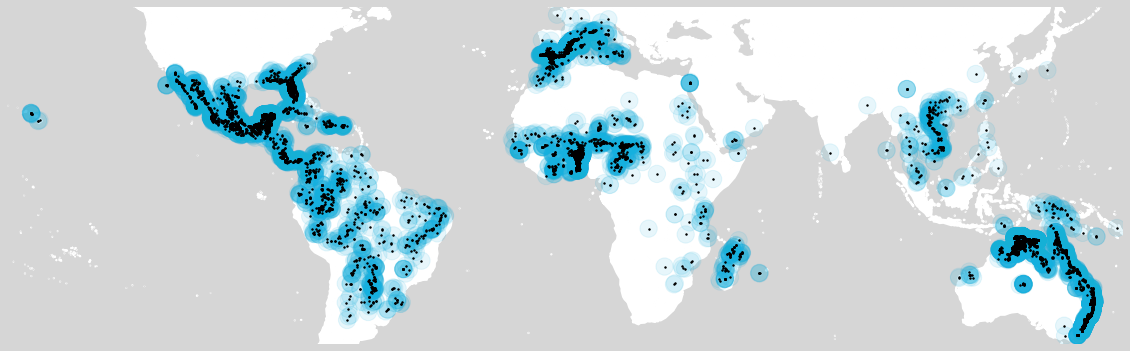

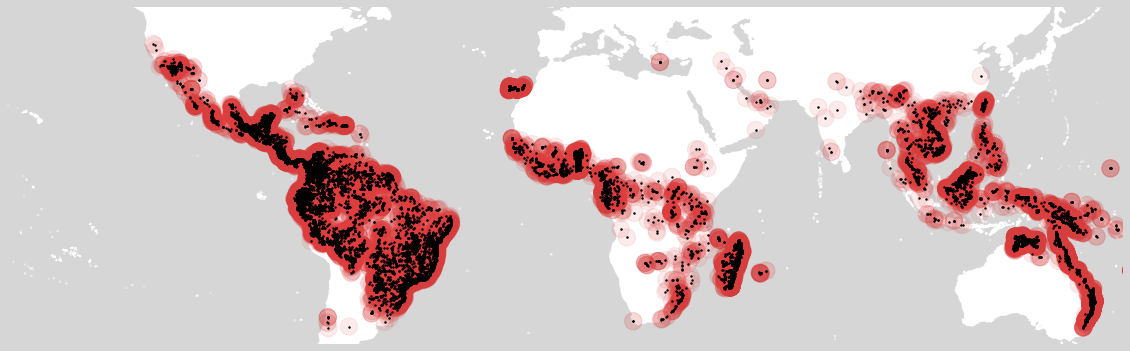

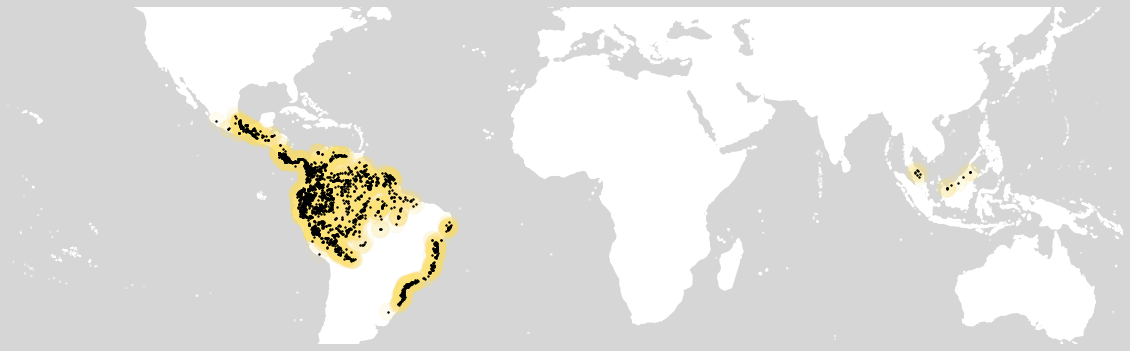

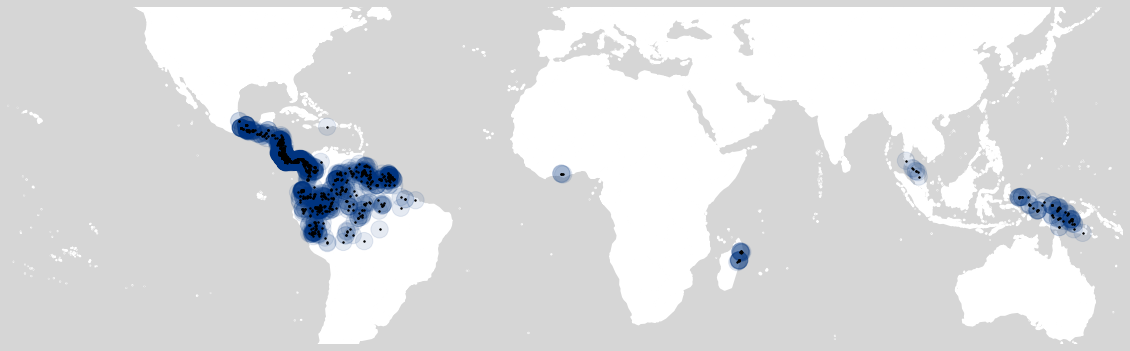

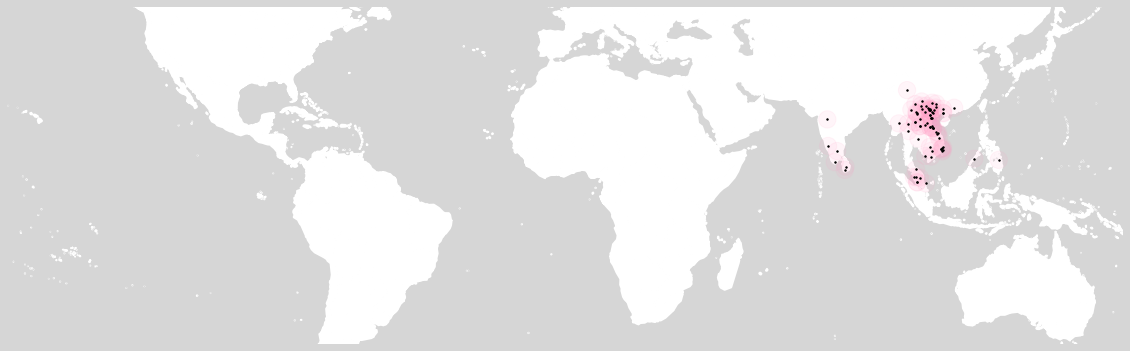

In [25]:
# colors pass greyscale differences and four colour deficiencies
shape_col_doct={'cos-palmate':"#15b0de", #light blue
'entire':"#003480", # dark blue
'variable':"#fbe279", # yellow
'pinnate':"#dd3d3d", # red
'bipinnate':"#ffa1c9",
'none':'#ff91e2'}

for shape in palms['shape'].unique():
    fig,ax=plt.subplots(figsize=(20,6.2),facecolor='#d6d6d6')
    ax.set_facecolor('#d6d6d6')
    for loc in polygons.keys():
        ax.add_collection(PatchCollection(polygons[loc],facecolor='w',edgecolor='w',alpha=1,linewidth=2)) ## plot polygons
    
    lon=palms[palms['shape']==shape]['decimalLongitude']
    lat=palms[palms['shape']==shape]['decimalLatitude']
    ax.scatter(lon,lat,marker='o',color=palms[palms['shape']==shape]['shape'].map(shape_col_doct),alpha=0.1,s=300)
    ax.scatter(lon,lat,marker='o',color='k',alpha=1,s=2)
#     ax.set_aspect('equal')
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.tick_params(size=0)
    ax.set_xticklabels([]) ; ax.set_yticklabels([])
    ax.set_xlim(-165,162) ; ax.set_ylim(-40,50)

    plt.show()
    

In [26]:
# adding genera info from the species name
for index,row in palms_spp.iterrows():
    tempmatch=re.search('([A-Z][a-z]+)_[a-z-]+',str(row['species']))
    palms_spp.loc[index,'genus']=tempmatch.groups(1) if tempmatch else 'unknown'
# print(palms['genus'].unique())

Arecoideae=['Acanthophoenix','Actinokentia','Actinorhytis','Adonidia','Archontophoenix','Areca','Balaka','Basselinia','Bentinckia','Brassiophoenix','Burretiokentia','Calyptrocalyx','Carpentaria','Carpoxylon','Chambeyronia','Clinosperma','Clinostigma','Cyphokentia','Cyphophoenix','Cyphosperma','Cyrtostachys','Deckenia','Dictyosperma','Dransfieldia','Drymophloeus','Dypsis','Hedyscepe','Heterospathe','Howea','Hydriastele','Iguanura','Kentiopsis','Laccospadix','Lemurophoenix','Lepidorrhachis','Linospadix','Loxococcus','Marojejya','Masoala','Nenga','Neoveitchia','Nephrosperma','Normanbya','Oncosperma','Phoenicophorium','Physokentia','Pinanga','Ponapea','Ptychococcus','Ptychosperma','Rhopaloblaste','Rhopalostylis','Roscheria','Satakentia','Solfia','Tectiphiala','Veitchia','Verschaffeltia','Wodyetia','Chamaedorea','Gaussia','Hyophorbe','Synechanthus','Wendlandiella','Acrocomia','Aiphanes','Allagoptera','Astrocaryum','Atitara','Attalea','Bactris','Barcella','Beccariophoenix','Butia','Cocos','Desmoncus','Elaeis','Jubaea','Jubaeopsis','Lytocaryum','Parajubaea','Polyandrococos','Syagrus','Voanioala','Euterpe','Hyospathe','Neonicholsonia','Oenocarpus','Prestoea','Asterogyne','Calyptrogyne','Calyptronoma','Geonoma','Pholidostachys','Welfia','Dictyocaryum','Iriartea','Iriartella','Socratea','Wettinia','Leopoldinia','Manicaria','Orania','Pelagodoxa','Sommieria','Podococcus','Reinhardtia','Roystonea','Sclerosperma']
Calamoideae=['Calamus','Ceratolobus','Daemonorops','Eleiodoxa','Korthalsia','Metroxylon','Myrialepis','Pigafetta','Plectocomia','Plectocomiopsis','Salacca','Pogonotium','Retispatha','Eugeissona','Eremospatha','Laccosperma','Lepidocaryum','Mauritia','Mauritiella','Oncocalamus','Raphia']
Ceroxyloideae=['Ceroxylon','Juania','Oraniopsis','Ravenea','Ammandra','Aphandra','Phytelephas','Pseudophoenix']
Coryphoideae=['Acoelorrhaphe','Arenga','Bismarckia','Borassodendron','Borassus','Brahea','Caryota','Chamaerops','Chelyocarpus','Chuniophoenix','Coccothrinax','Colpothrinax','Copernicia','Corypha','Cryosophila','Guihaia','Hemithrinax','Hyphaene','Itaya','Johannesteijsmannia','Kerriodoxa','Latania','Leucothrinax','Licuala','Livistona','Lodoicea','Maxburretia','Medemia','Nannorrhops','Phoenix','Pholidocarpus','Pritchardia','Rhapidophyllum','Rhapis','Sabal','Sabinaria','Saribus','Satranala','Schippia','Serenoa','Tahina','Thrinax','Trachycarpus','Trithrinax','Wallichia','Washingtonia','Zombia']
Nypoideae=['Nypa']

for index,row in palms_spp.iterrows():
    if row['genus'] in Arecoideae:
        palms_spp.loc[index,'subfam']='Arecoideae'
    if row['genus'] in Calamoideae:
        palms_spp.loc[index,'subfam']='Calamoideae'
    if row['genus'] in Ceroxyloideae:
        palms_spp.loc[index,'subfam']='Ceroxyloideae'
    if row['genus'] in Coryphoideae:
        palms_spp.loc[index,'subfam']='Coryphoideae'
    if row['genus'] in Nypoideae:
        palms_spp.loc[index,'subfam']='Nypoideae'
print(palms_spp['subfam'].unique())

[nan 'Arecoideae' 'Ceroxyloideae' 'Coryphoideae' 'Calamoideae' 'Nypoideae']


In [27]:
treeFileNexus='C://Users/xtorrm/Documents/Palm_leaf/Clean_1_1_MCCT_nexus.nex'
cc=bt.loadNexus(treeFileNexus,absoluteTime=False,tip_regex='_([0-9\-]+)$') ## treeFile here can alternatively be a path to a local file

cc.treeStats()
cc.drawTree()
cc.sortBranches()
cc.setAbsoluteTime(2018.0)


Tree height: 108.328870
Tree length: 18144.538310
strictly bifurcating tree
annotations present

Numbers of objects in tree: 5099 (2549 nodes and 2550 leaves)



### Shape colour directory

In [28]:
spp_shape_col=dict(zip(palms_spp['tip_name'],palms_spp['shape'].replace(np.nan,'none').map(shape_col_doct)))

dic_branchcolor={} # by shape
for k in cc.Objects:
    if k.branchType=='leaf':
        dic_branchcolor[k.index]=spp_shape_col[k.name] if k.name in spp_shape_col.keys() else 'none' # by shape
dic_branchcolor[10]

'#dd3d3d'

### Subfamily colour directory

In [29]:
spp_subfam_dict=dict(zip(palms_spp['tip_name'],palms_spp['subfam'].replace(np.nan,'none')))

for k in cc.Objects:
    if isinstance(k,bt.leaf):
        cur_node=k
        while cur_node:
            cur_node.traits['subfamily']=spp_subfam_dict[k.name] if k.name in spp_subfam_dict.keys() else 'none'
            cur_node=cur_node.parent

In [48]:
Subfam_col_dict={'Arecoideae':'#83B4D6', #blue
'Calamoideae':'#BEDA89', # green
'Ceroxyloideae':'#ffe27a',# orange
'Coryphoideae':'#F1978B', #red
'Nypoideae':'#545454','none':'#a3a3a3'}

spp_to_subfam=dict(zip(palms_spp['tip_name'],palms_spp['subfam'].replace(np.nan,'none').map(Subfam_col_dict)))

dic_subfamcolor={}
for k in cc.Objects:
    if k.branchType=='leaf':
        dic_subfamcolor[k.index]=spp_to_subfam[k.name] if k.name in spp_to_subfam.keys() else 'none'

dic_subfamcolor[10]
Subfam_col_dict

{'Arecoideae': '#83B4D6',
 'Calamoideae': '#BEDA89',
 'Ceroxyloideae': '#ffe27a',
 'Coryphoideae': '#F1978B',
 'Nypoideae': '#545454',
 'none': '#a3a3a3'}

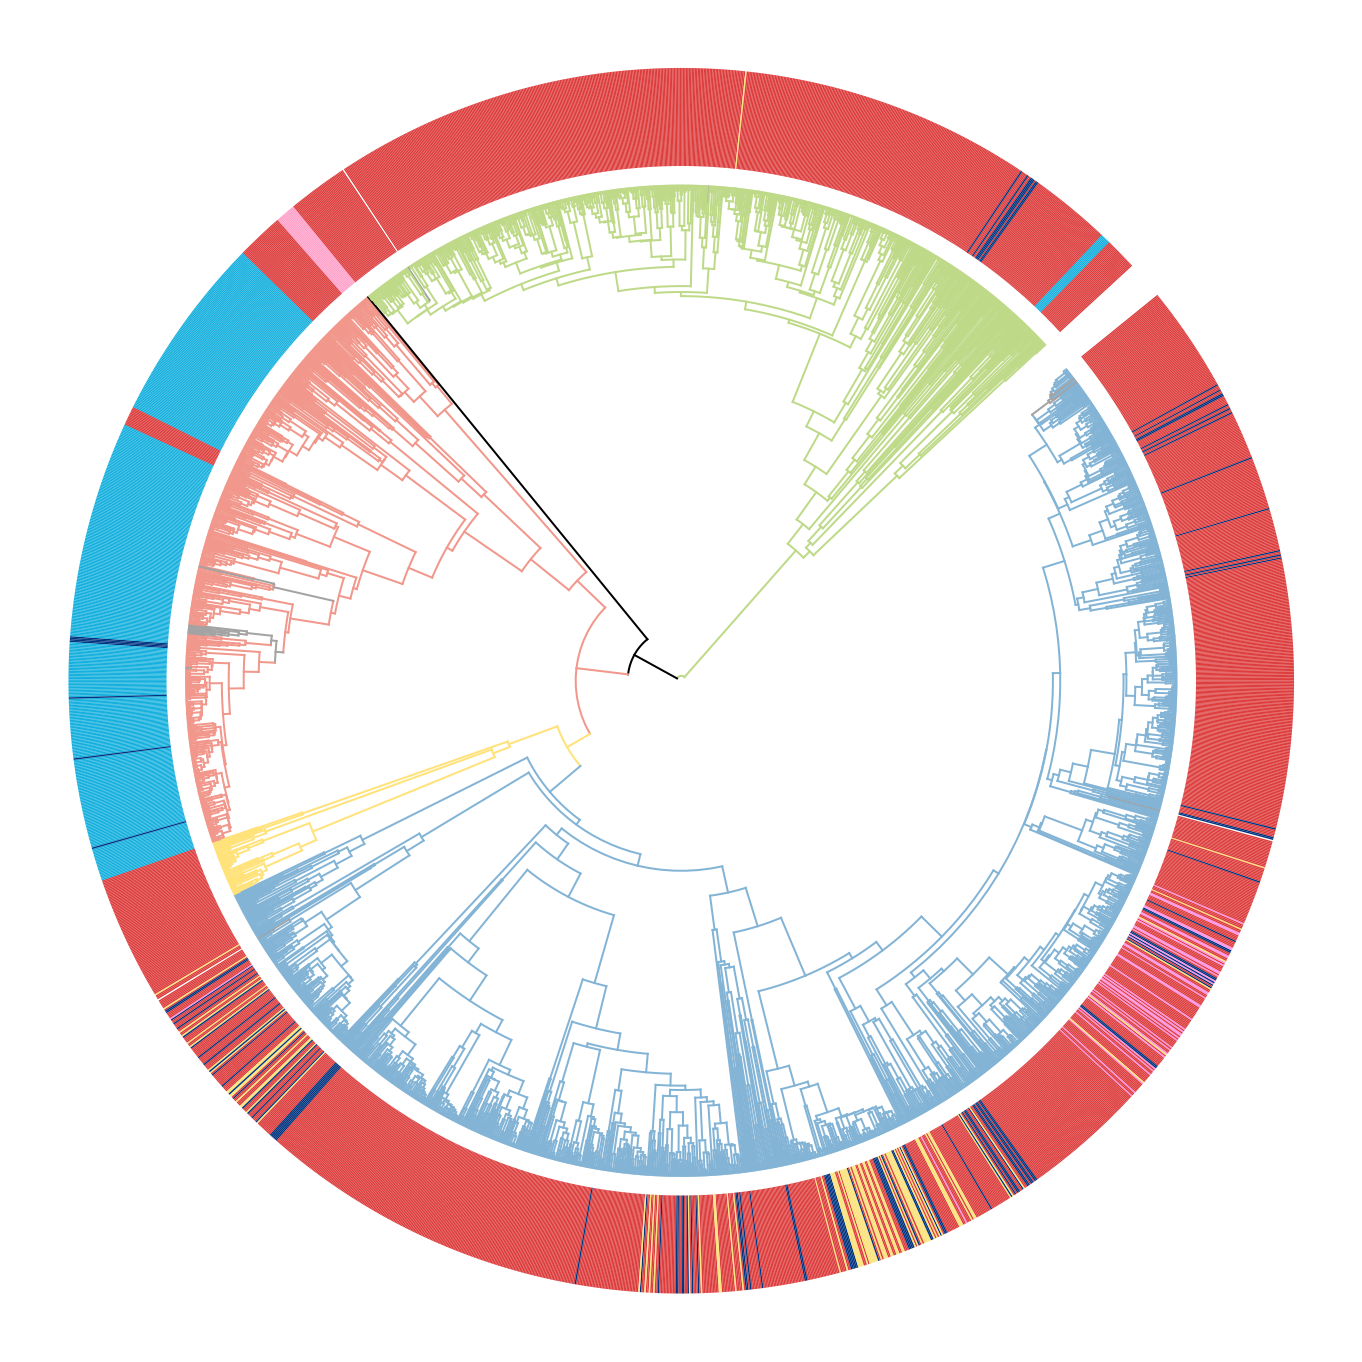

In [31]:
# shape
from matplotlib.patches import Polygon

fig,ax=plt.subplots(figsize=(24.8,24.8),facecolor='w')

circFrac=1/float(1) ## what fraction of the circle a single tree occupies
startFrom=np.pi ## start at some point along the circle
all_tips=[r.name for r in cc.Objects if isinstance(r,bt.leaf)] ## get all tip names from a tree
randomTip=np.random.randint(0,len(all_tips)) ## pick random tip
controlDepth=cc.treeHeight ## find the height of the highest tree
branchWidth=2 ## default branch width
inwardSpace=0.01
gap=0.99
effects=[path_effects.Stroke(linewidth=4, foreground='white'),path_effects.Stroke(linewidth=0.5, foreground='black')] ## black text, white outline
baseCircle=2*np.pi*startFrom ## tree starts here along the circle
leaves=[w.name for w in cc.Objects if isinstance(w,bt.leaf)] ## fetch names of tips in the tree
leafCount=len(leaves) ## count leaves in the tree
mostRecent=2018 ## find the most recent tip
if inwardSpace<0.0:
    labelX=-abs(inwardSpace)*1.05
else:
    labelX=inwardSpace+1.05
labelY=baseCircle+circFrac*np.pi

maxTreeHeight=max([k.absoluteTime for k in cc.Objects])
for k in cc.Objects:
# for k in cc.Objects[:100]: ## iterate through objects in the tree
    y=k.y ## get y position of current object
    x=maxTreeHeight-k.height
    xp=x-(k.parent.height-k.height)
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    xc=inwardSpace+((mostRecent-x)/controlDepth) ## transform x coordinate
    xpc=inwardSpace+((mostRecent-xp)/controlDepth) ## transform x parent's coordinate
    yc=baseCircle+circFrac*np.pi*2*(y/float(leafCount))*gap ## transform y coordinate

    if isinstance(k,bt.leaf): ## if leaf...
        begin_x=1.05
        end_x=1.25
        begin_y=baseCircle+circFrac*np.pi*2*((y-0.5)/float(leafCount))*gap
        end_y=baseCircle+circFrac*np.pi*2*((y+0.5)/float(leafCount))*gap
        ybar=np.linspace(begin_y,end_y,5)
        bottom_xs=np.sin(ybar)*begin_x
        bottom_ys=np.cos(ybar)*begin_x
        
        top_xs=np.sin(ybar)*end_x
        top_ys=np.cos(ybar)*end_x
        
        poly=plt.Polygon(list(zip(bottom_xs,bottom_ys))+list(zip(top_xs,top_ys))[::-1],
                         facecolor=dic_branchcolor[k.index] if k.index in dic_branchcolor.keys() else '#a3a3a3', edgecolor='none',zorder=11)
        
        ax.add_patch(poly)

    elif isinstance(k,bt.node): ## if node...
        yl=k.children[-1].y ## fetch first child y coordinate
        yr=k.children[0].y ## fetch last child y coordinate

        ycl=baseCircle+circFrac*np.pi*2*(yl/float(leafCount))*gap ## transform coordinates of first child
        ycr=baseCircle+circFrac*np.pi*2*(yr/float(leafCount))*gap ## transform coordinates of last child
                
        ybar=np.linspace(ycl,ycr,15) ## create a curved bar
        ax.plot(np.sin(ybar)*xc,np.cos(ybar)*xc,lw=branchWidth,
                color=Subfam_col_dict[k.traits['subfamily']] if 'subfamily' in k.traits else '#a3a3a3',
                ls='-',zorder=9) ## plot curved bar at the base of a node

    ax.plot([np.sin(yc)*xc,np.sin(yc)*xpc],[np.cos(yc)*xc,np.cos(yc)*xpc],lw=branchWidth,
            color=Subfam_col_dict[k.traits['subfamily']] if 'subfamily' in k.traits else '#a3a3a3',
            ls='-',zorder=9) ## plot ancestral branch
#         ax.text(x,yc,'x=%s, yc=%s'%(x,yc,))
    startFrom+=circFrac ## increment position along circle for next tree
#Remember, if center of circle is x = 0 and y = 0, then any point's coordinates can be found from x2 + y2 = R2 (where R is radius)
ax.tick_params(axis='x',size=0) ## no labels
ax.tick_params(axis='y',size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
ax.set_aspect(1) ## aspect set to 1 for proper circular plot

plt.show()

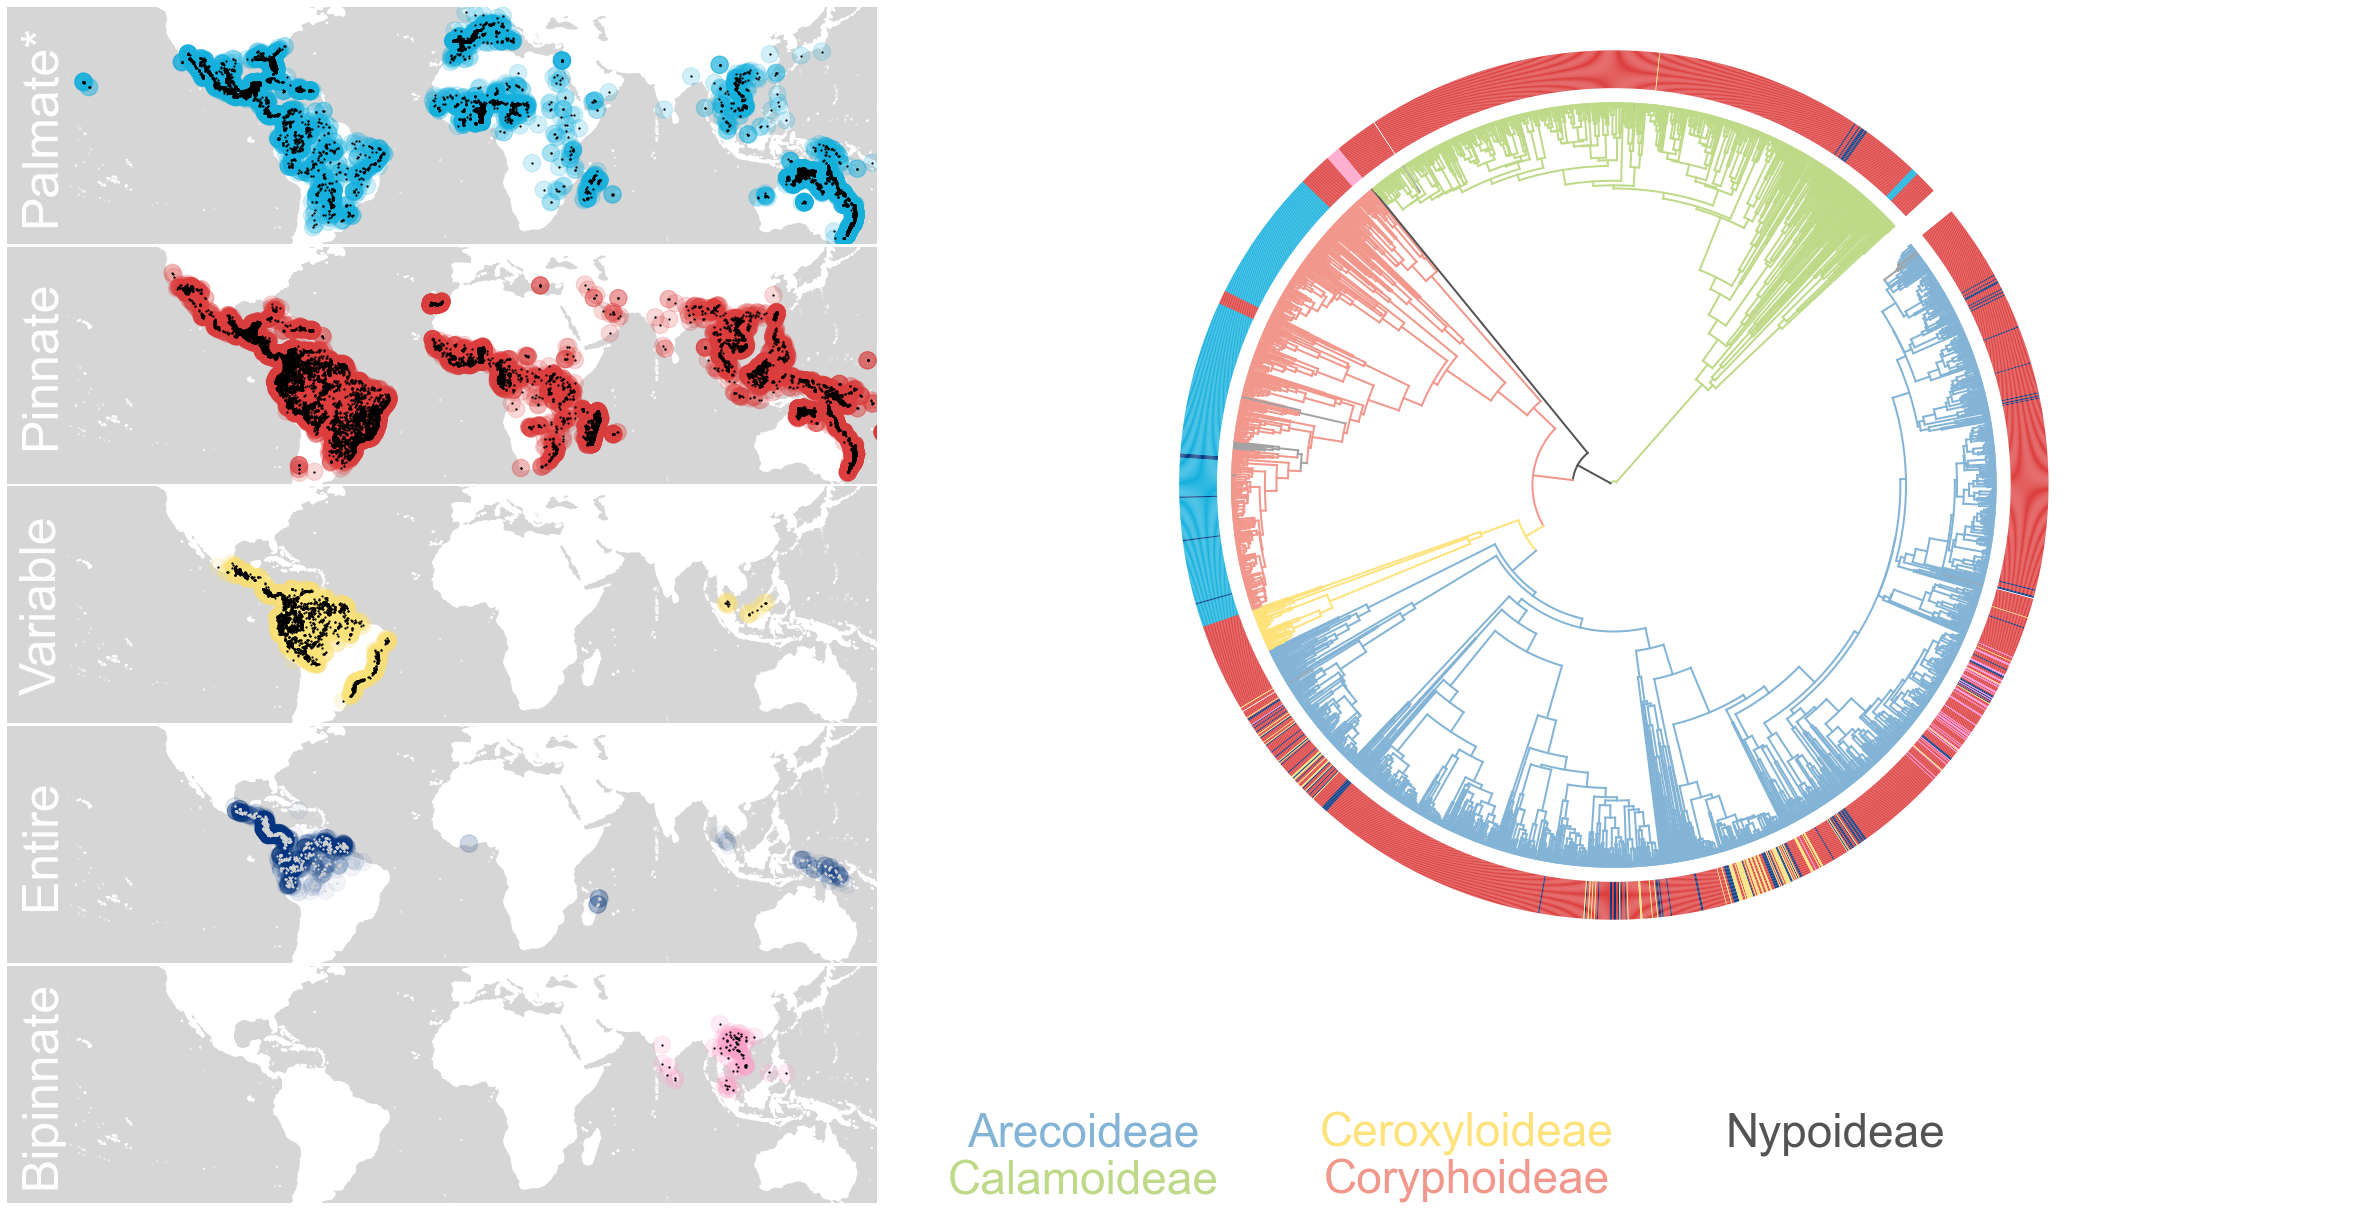

In [59]:
# colors pass greyscale differences and four colour deficiencies
# fig,ax=plt.subplots(figsize=(20,6.2),facecolor='#d6d6d6')
plt.figure(figsize=(42,22),facecolor='w')
G = gridspec.GridSpec(5,3,hspace=0.01,wspace=0,width_ratios=[0.08,1.1,2])

shape_text_dict={'cos-palmate':'Palmate*','entire':'Entire','variable':'Variable','pinnate':'Pinnate','bipinnate':'Bipinnate'}
xx=0
for shape in palms['shape'].unique():
    ####################### text boxes
    ax=plt.subplot(G[xx,0],facecolor='#d6d6d6')
    ax.set_facecolor('#d6d6d6')
    ax.text(0.2,0.5,'%s'%(shape_text_dict[shape]),fontname='Arial',rotation=90,color='w',size=50,va='center')
    ax.set_xticklabels([]) ; ax.set_yticklabels([])
    ax.tick_params(size=0)
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ####################### maps
    ax=plt.subplot(G[xx,1],facecolor='#d6d6d6')
    ax.set_facecolor('#d6d6d6')
    
    for loc in polygons.keys():
        ax.add_collection(PatchCollection(polygons[loc],facecolor='w',edgecolor='w',alpha=1,linewidth=2)) ## plot polygons
    
    lon=palms[palms['shape']==shape]['decimalLongitude']
    lat=palms[palms['shape']==shape]['decimalLatitude']
    ax.scatter(lon,lat,marker='o',color=palms[palms['shape']==shape]['shape'].map(shape_col_doct),alpha=0.05 if shape=='entire' else 0.2,s=300)
    ax.scatter(lon,lat,marker='o',color='#d1d1d1' if shape =='entire' else 'k',alpha=1,s=1.5)
#     ax.set_aspect('equal')
    ax.set_xticklabels([]) ; ax.set_yticklabels([])
    ax.tick_params(size=0)
    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.set_xlim(-165,162) ; ax.set_ylim(-40,50)
    xx+=1
    
########################## phylogeny
ax4=plt.subplot(G[0:4,2])
circFrac=1/float(1) ## what fraction of the circle a single tree occupies
startFrom=np.pi ## start at some point along the circle
all_tips=[r.name for r in cc.Objects if isinstance(r,bt.leaf)] ## get all tip names from a tree
randomTip=np.random.randint(0,len(all_tips)) ## pick random tip
controlDepth=cc.treeHeight ## find the height of the highest tree
branchWidth=2 ## default branch width
inwardSpace=0.01
gap=0.99
effects=[path_effects.Stroke(linewidth=4, foreground='white'),path_effects.Stroke(linewidth=0.5, foreground='black')] ## black text, white outline
baseCircle=2*np.pi*startFrom ## tree starts here along the circle
leaves=[w.name for w in cc.Objects if isinstance(w,bt.leaf)] ## fetch names of tips in the tree
leafCount=len(leaves) ## count leaves in the tree
mostRecent=2018 ## find the most recent tip
if inwardSpace<0.0:
    labelX=-abs(inwardSpace)*1.05
else:
    labelX=inwardSpace+1.05
labelY=baseCircle+circFrac*np.pi

maxTreeHeight=max([k.absoluteTime for k in cc.Objects])
for k in cc.Objects:
# for k in cc.Objects[:100]: ## iterate through objects in the tree
    y=k.y ## get y position of current object
    x=maxTreeHeight-k.height
    xp=x-(k.parent.height-k.height)
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    xc=inwardSpace+((mostRecent-x)/controlDepth) ## transform x coordinate
    xpc=inwardSpace+((mostRecent-xp)/controlDepth) ## transform x parent's coordinate
    yc=baseCircle+circFrac*np.pi*2*(y/float(leafCount))*gap ## transform y coordinate

    if isinstance(k,bt.leaf): ## if leaf...
        begin_x=1.05
        end_x=1.15
        begin_y=baseCircle+circFrac*np.pi*2*((y-0.5)/float(leafCount))*gap
        end_y=baseCircle+circFrac*np.pi*2*((y+0.5)/float(leafCount))*gap
        ybar=np.linspace(begin_y,end_y,5)
        bottom_xs=np.sin(ybar)*begin_x
        bottom_ys=np.cos(ybar)*begin_x
        
        top_xs=np.sin(ybar)*end_x
        top_ys=np.cos(ybar)*end_x
        
        poly=plt.Polygon(list(zip(bottom_xs,bottom_ys))+list(zip(top_xs,top_ys))[::-1],
                         facecolor=dic_branchcolor[k.index] if k.index in dic_branchcolor.keys() else '#a3a3a3', edgecolor='none',zorder=11)
        
        ax4.add_patch(poly)

    elif isinstance(k,bt.node): ## if node...
        yl=k.children[-1].y ## fetch first child y coordinate
        yr=k.children[0].y ## fetch last child y coordinate

        ycl=baseCircle+circFrac*np.pi*2*(yl/float(leafCount))*gap ## transform coordinates of first child
        ycr=baseCircle+circFrac*np.pi*2*(yr/float(leafCount))*gap ## transform coordinates of last child
                
        ybar=np.linspace(ycl,ycr,15) ## create a curved bar
        ax4.plot(np.sin(ybar)*xc,np.cos(ybar)*xc,lw=branchWidth,
                color=Subfam_col_dict[k.traits['subfamily']] if 'subfamily' in k.traits else '#a3a3a3',
                ls='-',zorder=9) ## plot curved bar at the base of a node

    ax4.plot([np.sin(yc)*xc,np.sin(yc)*xpc],[np.cos(yc)*xc,np.cos(yc)*xpc],lw=branchWidth,
            color=Subfam_col_dict[k.traits['subfamily']] if 'subfamily' in k.traits else '#a3a3a3',
            ls='-',zorder=9) ## plot ancestral branch
#         ax4.text(x,yc,'x=%s, yc=%s'%(x,yc,))
    startFrom+=circFrac ## increment position along circle for next tree
    ax4.set_aspect(1) ## aspect set to 1 for proper circular plot

ax4.set_xticklabels([]) ; ax4.set_yticklabels([])
[ax4.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
ax4.tick_params(size=0)

ax5=plt.subplot(G[4,2])
subfam_xy_dict={'Arecoideae':(0.14,0.2),
'Calamoideae':(0.14,0),
'Ceroxyloideae':(0.4,0.2),
'Coryphoideae':(0.4,0),
'Nypoideae':(0.65,0.2)}

for key,value in Subfam_col_dict.items():
    if key != 'none':
        ax5.text(subfam_xy_dict[key][0],subfam_xy_dict[key][1],'%s'%(key),fontname='Arial',rotation=0,color=Subfam_col_dict[key],size=46,va='bottom',ha='center')
ax5.set_xticklabels([]) ; ax5.set_yticklabels([])
[ax5.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
ax5.tick_params(size=0)
# plt.savefig('./Figure_1_20200421.svg')
plt.savefig('./Figure_1_20200421.png',dpi=350)
# plt.savefig('./Figure_1_20200421.pdf')
plt.show()
    